In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib



In [2]:
fake_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
true_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')


In [3]:
fake_df['label'] = 0  
true_df['label'] = 1  

In [11]:
news_df = pd.concat([fake_df, true_df], ignore_index=True)
news_df = news_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [12]:
news_df.drop(['title', 'subject', 'date'], axis=1, inplace=True)


In [13]:
news_df.head(10)

,text,label
0,"21st Century Wire says Ben Stein, reputable pr...",0
1,WASHINGTON (Reuters) - U.S. President Donald T...,1
2,(Reuters) - Puerto Rico Governor Ricardo Rosse...,1
3,"On Monday, Donald Trump once again embarrassed...",0
4,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",1
5,"On Wednesday, Democrats took a powerful stance...",0
6,President Trump s rally in FL on Saturday was ...,0
7,He s been Europe s version of the outspoken Te...,0
8,WASHINGTON (Reuters) - The State Department sa...,1
9,(This version of the story corrects the figur...,1


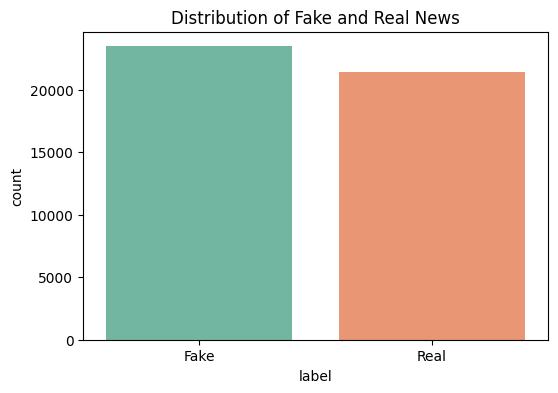

In [14]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=news_df, palette='Set2')
plt.title('Distribution of Fake and Real News')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()


In [15]:
news_df['word_count'] = news_df['text'].apply(lambda x: len(x.split()))
news_df['char_count'] = news_df['text'].apply(len)
news_df['avg_word_length'] = news_df['char_count'] / news_df['word_count']
news_df['stopword_count'] = news_df['text'].apply(lambda x: len([word for word in x.split() if word.lower() in stopwords.words('english')]))


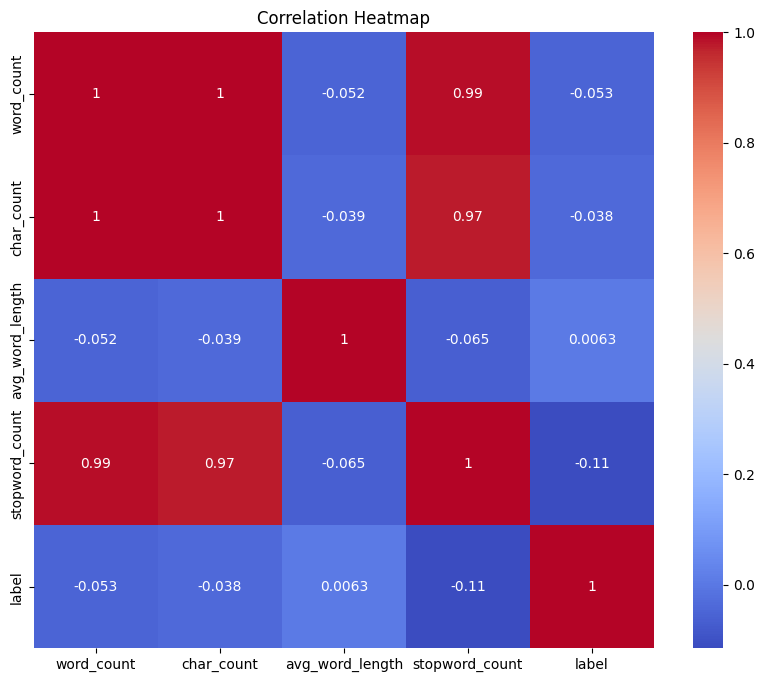

In [16]:
plt.figure(figsize=(10,8))
sns.heatmap(news_df[['word_count', 'char_count', 'avg_word_length', 'stopword_count', 'label']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [17]:
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)


In [18]:
news_df['clean_text'] = news_df['text'].apply(preprocess_text)


In [19]:
vectorizer = TfidfVectorizer(max_df=0.7)
X = vectorizer.fit_transform(news_df['clean_text'])
y = news_df['label']


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
from sklearn.linear_model import SGDClassifier
epochs = 10
model = SGDClassifier(loss='log', max_iter=epochs, tol=None, random_state=42)
model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


SGDClassifier(loss='log', max_iter=10, random_state=42, tol=None)

In [27]:
predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))


Accuracy: 0.976837416481069

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      4710
           1       0.97      0.98      0.98      4270

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



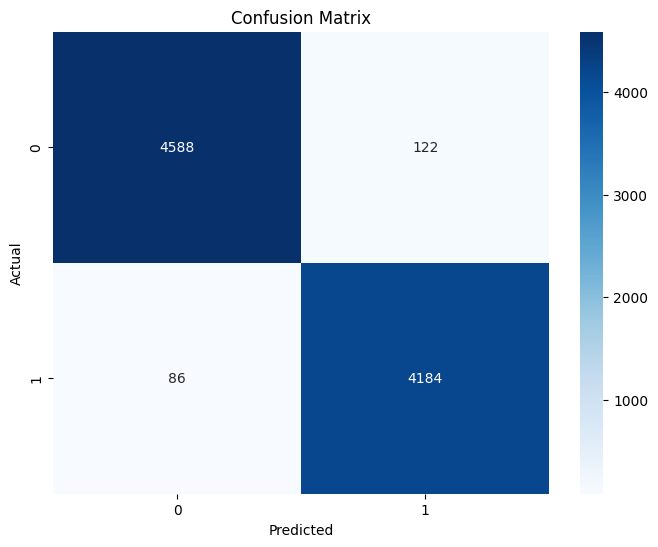

In [28]:
plt.figure(figsize=(8,6))
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


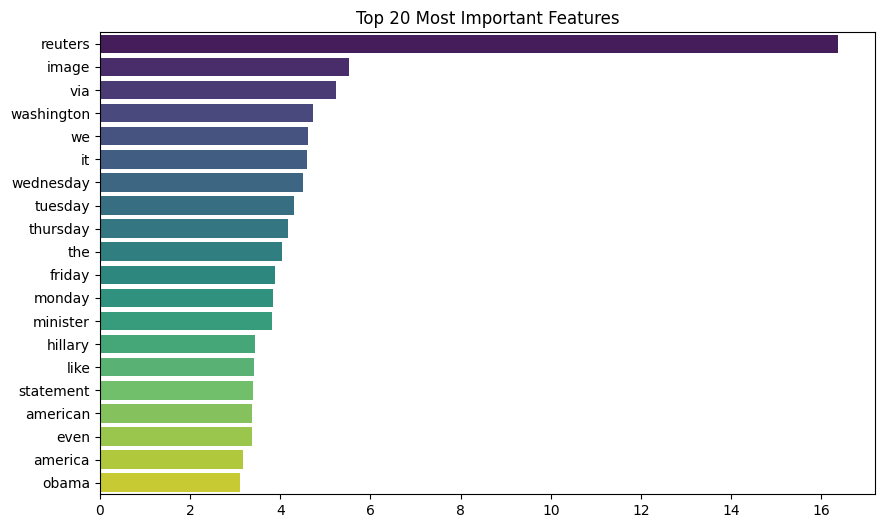

In [29]:
importance = np.abs(model.coef_[0])
indices = np.argsort(importance)[-20:][::-1]
features = np.array(vectorizer.get_feature_names_out())[indices]
plt.figure(figsize=(10,6))
sns.barplot(x=importance[indices], y=features, palette='viridis')
plt.title('Top 20 Most Important Features')
plt.show()

